## Install and import dependencies

Also download the dataset if not exist

In [1]:
    # !pip install -q torch_snippets pytorch_model_summary
    # !pip install -q scikit-learn

In [2]:
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from torchvision import transforms, models

from torch_snippets import *
import glob

### Define the Configs and Transforms

In [3]:
class config:
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3 
    N_EPOCHS = 100

In [4]:
def get_transforms():
    
    return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225],
                )
    ])

In [5]:
# input_folder = 'dataset1/'
# splitfolders.ratio(input_folder, output ="dataset2", seed=42, ratio =(.7, .2, .1), group_prefix=None)  

In [6]:
#Aerial Semantic Segmentation Drone Dataset
orignal_images_path = "dataset2/train7/images_prepped_train/"
label_images_path = "dataset2/train7/annotations_prepped_train/"

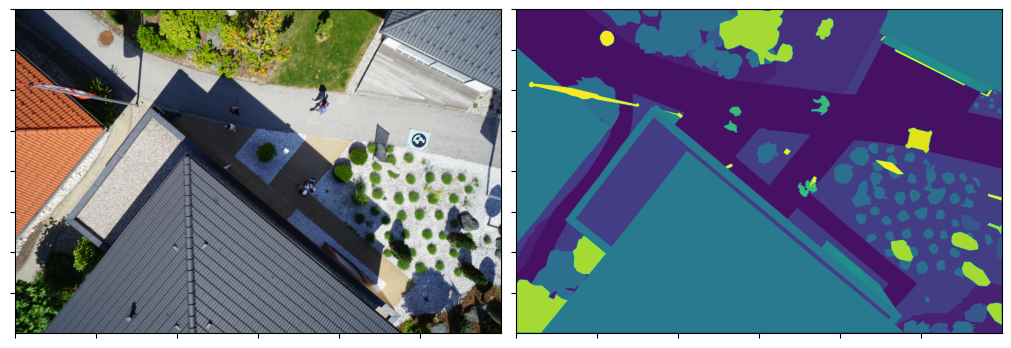

In [7]:
# Show input sample 
 
fig, axs = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].imshow( Image.open(orignal_images_path+"005.jpg"))

axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
label_image_semantic = Image.open(label_images_path+"005.png")
axs[1].imshow(label_image_semantic)


## Define the dataset

In [8]:
class SegDataset(Dataset):
    
    def __init__(self, split):
        self.items = stems(f'dataset2/train7/images_prepped_{split}')
        self.split = split
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, ix):
        
        image = read(f'dataset2/train7/images_prepped_{self.split}/{self.items[ix]}.jpg', 1)
        image = cv2.resize(image, (224, 224))
        
        mask = read(f'dataset2/train7/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224, 224))
        
        return image, mask
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        
        ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(config.DEVICE)
        mks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)
        
        return ims, mks

## Define the  DataLoading

In [9]:
def get_dataloaders():
    
    trn_ds = SegDataset('train')
    val_ds = SegDataset('test')
    
    trn_dl = DataLoader(trn_ds, batch_size=8, shuffle=True, collate_fn=trn_ds.collate_fn)
    val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=val_ds.collate_fn)
    
    return trn_dl, val_dl

In [10]:
trn_dl, val_dl = get_dataloaders()

In [11]:
val_ds = SegDataset('train')

In [12]:
len(val_ds)

280

## Mask checking

In [13]:
import cv2

In [14]:
# ex_img  = 'dataset1/images_prepped_train/0001TP_006690.png' 
# ex_mask = 'dataset1/annotations_prepped_train/0001TP_006690.png'

In [15]:
### UNet Architecture

In [16]:
# Define the Convolution block
def conv(in_channels, out_channels):
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [17]:
# Define the UpConvolution block
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
    )

In [18]:
#Leverage building blocks and create the entire architecture

In [19]:
encoder = models.vgg16_bn(pretrained=True).features

C:\Users\USER\miniconda3\envs\unet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\miniconda3\envs\unet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [21]:
class UNet(nn.Module):
    
    def __init__(self, weights='VGG16_BN_Weights.DEFAULT', out_channels=23):
        
        super().__init__()
        
        self.encoder = models.vgg16_bn(weights=weights).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)
        
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        bottleneck = self.bottleneck(block5)
        
        x = self.conv_bottleneck(bottleneck)
        
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        
        x = self.conv11(x)
        
        return x

In [22]:
model = UNet()
model

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [23]:
## Loss Function

In [24]:
CrossEnt = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    loss = CrossEnt(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

In [25]:
### Train

In [26]:
class Train():
    
    def train_batch(model, data, optimizer, criterion):
        
        model.train()
        
        imgs, masks = data
        _masks = model(imgs)
        optimizer.zero_grad()
        loss, acc = criterion(_masks, masks)
        loss.backward()
        optimizer.step()
        
        return loss.item(), acc.item()
    
    @torch.no_grad()
    def valid_batch(model, data, criterion):
        
        model.eval()

        imgs, masks = data
        _masks = model(imgs)

        loss, acc = criterion(_masks, masks)
        
        return loss.item(), acc.item()

In [27]:
### Define model, loss and optimizer

In [28]:
model = UNet().to(config.DEVICE)

criterion = UnetLoss

optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE) 

In [29]:
len(val_dl)

5

In [30]:
for epoch in range(config.N_EPOCHS):
    
    train_loss_log = []
    train_acc_log  = []
    val_loss_log   = []
    val_acc_log    = []
    
    # for bx, data in tqdm(enumerate(trn_dl)):
    for data in trn_dl:
        train_loss, train_acc = Train.train_batch(model, data, optimizer, criterion)       
        
    # for bx, data in tqdm(enumerate(val_dl)):
    for data in val_dl:
        val_loss, val_acc = Train.valid_batch(model, data, criterion)
    
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
    
    print('##########################################')
    print(f'Epoch: {epoch}, \tTrain_loss: {train_loss}, \tTrain_acc: {train_acc}, \tVal_loss: {val_loss}, \tVal_acc: {val_acc}')
    print('##########################################')

##########################################

Epoch: 0,       Train_loss: 1.8266966342926025,         Train_acc: 0.6383754014968872,  Val_loss: 
2.589095115661621,    Val_acc: 0.3748604953289032

##########################################

##########################################

Epoch: 1,       Train_loss: 1.711290955543518,  Train_acc: 0.5289978981018066,  Val_loss: 1.4030767679214478,   
Val_acc: 0.6531409025192261

##########################################

##########################################

Epoch: 2,       Train_loss: 1.2748098373413086,         Train_acc: 0.6580511331558228,  Val_loss: 
1.0962952375411987,   Val_acc: 0.7271055579185486

##########################################

##########################################

Epoch: 3,       Train_loss: 1.1973727941513062,         Train_acc: 0.6880978941917419,  Val_loss: 
0.901435911655426,    Val_acc: 0.7968201637268066

##########################################

##########################################

Epoch: 4,       Train_loss: 1.0369609594345093,         Train_acc: 0.732332170009613,   Val_loss: 
1.2215814590454102,   Val_acc: 0.6461281180381775

##########################################

##########################################

Epoch: 5,       Train_loss: 1.0817826986312866,         Train_acc: 0.7124571204185486,  Val_loss: 
0.7340395450592041,   Val_acc: 0.8210922479629517

##########################################

##########################################

Epoch: 6,       Train_loss: 0.8941164612770081,         Train_acc: 0.7454485297203064,  Val_loss: 
0.6768513321876526,   Val_acc: 0.8390664458274841

##########################################

##########################################

Epoch: 7,       Train_loss: 0.8074806332588196,         Train_acc: 0.77384352684021,    Val_loss: 
0.7140766978263855,   Val_acc: 0.8183020353317261

##########################################

##########################################

Epoch: 8,       Train_loss: 0.8409786820411682,         Train_acc: 0.7528424859046936,  Val_loss: 
0.6321966052055359,   Val_acc: 0.8295972943305969

##########################################

##########################################

Epoch: 9,       Train_loss: 0.8713765144348145,         Train_acc: 0.7261564135551453,  Val_loss: 
0.6098307371139526,   Val_acc: 0.8498385548591614

##########################################

##########################################

Epoch: 10,      Train_loss: 0.887168288230896,  Train_acc: 0.7176264524459839,  Val_loss: 0.5320473313331604,   
Val_acc: 0.8617665767669678

##########################################

##########################################

Epoch: 11,      Train_loss: 0.7989025712013245,         Train_acc: 0.7559515237808228,  Val_loss: 
0.5163397789001465,   Val_acc: 0.8594023585319519

##########################################

##########################################

Epoch: 12,      Train_loss: 0.8671137094497681,         Train_acc: 0.7294248938560486,  Val_loss: 
0.5425586700439453,   Val_acc: 0.8520806431770325

##########################################

##########################################

Epoch: 13,      Train_loss: 0.6074170470237732,         Train_acc: 0.8154445886611938,  Val_loss: 
0.5691008567810059,   Val_acc: 0.8375841975212097

##########################################

##########################################

Epoch: 14,      Train_loss: 0.7181313037872314,         Train_acc: 0.788260281085968,   Val_loss: 
0.6565025448799133,   Val_acc: 0.8163663744926453

##########################################

##########################################

Epoch: 15,      Train_loss: 0.7670888304710388,         Train_acc: 0.7676827311515808,  Val_loss: 
0.5372012853622437,   Val_acc: 0.8399458527565002

##########################################

##########################################

Epoch: 16,      Train_loss: 0.5423479676246643,         Train_acc: 0.8410818576812744,  Val_loss: 
0.5141984820365906,   Val_acc: 0.8562759160995483

##########################################

##########################################

Epoch: 17,      Train_loss: 0.5460553765296936,         Train_acc: 0.8330775499343872,  Val_loss: 
0.5095812082290649,   Val_acc: 0.8561961650848389

##########################################

##########################################

Epoch: 18,      Train_loss: 0.5324448347091675,         Train_acc: 0.8255216479301453,  Val_loss: 
0.4401990473270416,   Val_acc: 0.8801742792129517

##########################################

##########################################

Epoch: 19,      Train_loss: 0.5111674666404724,         Train_acc: 0.8443105220794678,  Val_loss: 
0.4040564000606537,   Val_acc: 0.8769506216049194

##########################################

##########################################

Epoch: 20,      Train_loss: 0.4385344982147217,         Train_acc: 0.8662881255149841,  Val_loss: 
0.4152829647064209,   Val_acc: 0.8843919038772583

##########################################

##########################################

Epoch: 21,      Train_loss: 0.49919939041137695,        Train_acc: 0.848388671875,      Val_loss: 
0.45900002121925354,  Val_acc: 0.8689238429069519

##########################################

##########################################

Epoch: 22,      Train_loss: 0.3695871829986572,         Train_acc: 0.897024929523468,   Val_loss: 
0.40273264050483704,  Val_acc: 0.8831039667129517

##########################################

##########################################

Epoch: 23,      Train_loss: 0.4957127571105957,         Train_acc: 0.8563879728317261,  Val_loss: 
0.4495730400085449,   Val_acc: 0.8738789558410645

##########################################

##########################################

Epoch: 24,      Train_loss: 0.4781467914581299,         Train_acc: 0.8609718680381775,  Val_loss: 
0.4748802185058594,   Val_acc: 0.8540886044502258

##########################################

##########################################

Epoch: 25,      Train_loss: 0.4181595742702484,         Train_acc: 0.8740159273147583,  Val_loss: 
0.40978771448135376,  Val_acc: 0.8836794495582581

##########################################

##########################################

Epoch: 26,      Train_loss: 0.6496382355690002,         Train_acc: 0.8091542720794678,  Val_loss: 
0.4404323995113373,   Val_acc: 0.8597959876060486

##########################################

##########################################

Epoch: 27,      Train_loss: 0.377713143825531,  Train_acc: 0.8841652274131775,  Val_loss: 0.4648437201976776,   
Val_acc: 0.8694096803665161

##########################################

##########################################

Epoch: 28,      Train_loss: 0.30662083625793457,        Train_acc: 0.9052086472511292,  Val_loss: 
0.40122824907302856,  Val_acc: 0.8880490660667419

##########################################

##########################################

Epoch: 29,      Train_loss: 0.3761063814163208,         Train_acc: 0.89017653465271,    Val_loss: 
0.35998648405075073,  Val_acc: 0.8933752775192261

##########################################

##########################################

Epoch: 30,      Train_loss: 0.35288697481155396,        Train_acc: 0.8944240808486938,  Val_loss: 
0.34759408235549927,  Val_acc: 0.899568498134613

##########################################

##########################################

Epoch: 31,      Train_loss: 0.3207944631576538,         Train_acc: 0.9119001030921936,  Val_loss: 
0.36559024453163147,  Val_acc: 0.8940205574035645

##########################################

##########################################

Epoch: 32,      Train_loss: 0.35839682817459106,        Train_acc: 0.8949074149131775,  Val_loss: 
0.3413236141204834,   Val_acc: 0.8989133238792419

##########################################

##########################################

Epoch: 33,      Train_loss: 0.39336761832237244,        Train_acc: 0.8858318328857422,  Val_loss: 
0.37695690989494324,  Val_acc: 0.8907694816589355

##########################################

##########################################

Epoch: 34,      Train_loss: 0.3992413580417633,         Train_acc: 0.8743696808815002,  Val_loss: 
0.3539656102657318,   Val_acc: 0.8960085511207581

##########################################

##########################################

Epoch: 35,      Train_loss: 0.25132277607917786,        Train_acc: 0.9290024042129517,  Val_loss: 
0.38165876269340515,  Val_acc: 0.8925382494926453

##########################################

##########################################

Epoch: 36,      Train_loss: 0.3095604479312897,         Train_acc: 0.9097352027893066,  Val_loss: 
0.3632146120071411,   Val_acc: 0.8930364847183228

##########################################

##########################################

Epoch: 37,      Train_loss: 0.2504635155200958,         Train_acc: 0.9262471199035645,  Val_loss: 
0.38029834628105164,  Val_acc: 0.8924934267997742

##########################################

##########################################

Epoch: 38,      Train_loss: 0.29129835963249207,        Train_acc: 0.9131132960319519,  Val_loss: 
0.3732559084892273,   Val_acc: 0.8906224966049194

##########################################

##########################################

Epoch: 39,      Train_loss: 0.30326879024505615,        Train_acc: 0.9080785512924194,  Val_loss: 
0.6110277771949768,   Val_acc: 0.8325045704841614

##########################################

##########################################

Epoch: 40,      Train_loss: 0.43643930554389954,        Train_acc: 0.8631168007850647,  Val_loss: 
0.5824432969093323,   Val_acc: 0.8200060725212097

##########################################

##########################################

Epoch: 41,      Train_loss: 0.3804374635219574,         Train_acc: 0.8871148228645325,  Val_loss: 
0.4865727722644806,   Val_acc: 0.8646613955497742

##########################################

##########################################

Epoch: 42,      Train_loss: 0.26655352115631104,        Train_acc: 0.9192193150520325,  Val_loss: 
0.7618134021759033,   Val_acc: 0.7840052843093872

##########################################

##########################################

Epoch: 43,      Train_loss: 0.20888513326644897,        Train_acc: 0.9408556818962097,  Val_loss: 
0.3328840434551239,   Val_acc: 0.9027746915817261

##########################################

##########################################

Epoch: 44,      Train_loss: 0.3056732416152954,         Train_acc: 0.9092220067977905,  Val_loss: 
0.3377847373485565,   Val_acc: 0.9085144996643066

##########################################

##########################################

Epoch: 45,      Train_loss: 0.22862721979618073,        Train_acc: 0.9329111576080322,  Val_loss: 
0.34822067618370056,  Val_acc: 0.9016860723495483

##########################################

##########################################

Epoch: 46,      Train_loss: 0.2478642761707306,         Train_acc: 0.9252605438232422,  Val_loss: 
0.333849161863327,    Val_acc: 0.9043267369270325

##########################################

##########################################

Epoch: 47,      Train_loss: 0.1746104508638382,         Train_acc: 0.9475670456886292,  Val_loss: 
0.3337734043598175,   Val_acc: 0.9091871380805969

##########################################

##########################################

Epoch: 48,      Train_loss: 0.2590119242668152,         Train_acc: 0.92106032371521,    Val_loss: 
0.32364004850387573,  Val_acc: 0.9107416868209839

##########################################

##########################################

Epoch: 49,      Train_loss: 0.19656556844711304,        Train_acc: 0.9423030614852905,  Val_loss: 
0.32005953788757324,  Val_acc: 0.9112050533294678

##########################################

##########################################

Epoch: 50,      Train_loss: 0.17599351704120636,        Train_acc: 0.9476342797279358,  Val_loss: 
0.33945146203041077,  Val_acc: 0.9082205295562744

##########################################

##########################################

Epoch: 51,      Train_loss: 0.18627749383449554,        Train_acc: 0.9428113102912903,  Val_loss: 
0.32830363512039185,  Val_acc: 0.9109708666801453

##########################################

##########################################

Epoch: 52,      Train_loss: 0.18682675063610077,        Train_acc: 0.9445501565933228,  Val_loss: 
0.3269338011741638,   Val_acc: 0.9121666550636292

##########################################

##########################################

Epoch: 53,      Train_loss: 0.20476889610290527,        Train_acc: 0.9380430579185486,  Val_loss: 
0.34673362970352173,  Val_acc: 0.9094213247299194

##########################################

##########################################

Epoch: 54,      Train_loss: 0.17261405289173126,        Train_acc: 0.9498739242553711,  Val_loss: 
0.34672650694847107,  Val_acc: 0.9102209806442261

##########################################

##########################################

Epoch: 55,      Train_loss: 0.15469369292259216,        Train_acc: 0.9535933136940002,  Val_loss: 
0.36464598774909973,  Val_acc: 0.9018629193305969

##########################################

##########################################

Epoch: 56,      Train_loss: 0.16230109333992004,        Train_acc: 0.9514384269714355,  Val_loss: 
0.3767049312591553,   Val_acc: 0.9019002914428711

##########################################

##########################################

Epoch: 57,      Train_loss: 0.18901047110557556,        Train_acc: 0.9424375891685486,  Val_loss: 
0.42731425166130066,  Val_acc: 0.8906474113464355

##########################################

##########################################

Epoch: 58,      Train_loss: 0.23184834420681,   Train_acc: 0.9308807849884033,  Val_loss: 0.42365825176239014,  
Val_acc: 0.8937240839004517

##########################################

##########################################

Epoch: 59,      Train_loss: 0.2752544581890106,         Train_acc: 0.9183723330497742,  Val_loss: 
0.41192102432250977,  Val_acc: 0.8868258595466614

##########################################

##########################################

Epoch: 60,      Train_loss: 0.15096674859523773,        Train_acc: 0.9567995667457581,  Val_loss: 
0.4018566310405731,   Val_acc: 0.8919353485107422

##########################################

##########################################

Epoch: 61,      Train_loss: 0.2335965633392334,         Train_acc: 0.9384715557098389,  Val_loss: 
0.37034425139427185,  Val_acc: 0.9046431183815002

##########################################

##########################################

Epoch: 62,      Train_loss: 0.1946113407611847,         Train_acc: 0.9421859979629517,  Val_loss: 
0.3561980128288269,   Val_acc: 0.9081856608390808

##########################################

##########################################

Epoch: 63,      Train_loss: 0.17889684438705444,        Train_acc: 0.9452576637268066,  Val_loss: 
0.3393876850605011,   Val_acc: 0.9112175107002258

##########################################

##########################################

Epoch: 64,      Train_loss: 0.16239745914936066,        Train_acc: 0.9505490660667419,  Val_loss: 
0.3552752137184143,   Val_acc: 0.912649929523468

##########################################

##########################################

Epoch: 65,      Train_loss: 0.16163495182991028,        Train_acc: 0.9502226710319519,  Val_loss: 
0.3483048379421234,   Val_acc: 0.9127346277236938

##########################################

##########################################

Epoch: 66,      Train_loss: 0.12752404808998108,        Train_acc: 0.9610296487808228,  Val_loss: 
0.3562692403793335,   Val_acc: 0.9118452668190002

##########################################

##########################################

Epoch: 67,      Train_loss: 0.15704305469989777,        Train_acc: 0.952778697013855,   Val_loss: 
0.35362952947616577,  Val_acc: 0.9134247303009033

##########################################

##########################################

Epoch: 69,      Train_loss: 0.10164795815944672,        Train_acc: 0.9705735445022583,  Val_loss: 
0.39679187536239624,  Val_acc: 0.9055549502372742

##########################################

##########################################

Epoch: 70,      Train_loss: 0.1709587126970291,         Train_acc: 0.9470139741897583,  Val_loss: 
0.35932859778404236,  Val_acc: 0.9111751317977905

##########################################

##########################################

Epoch: 71,      Train_loss: 0.1775328814983368,         Train_acc: 0.9432248473167419,  Val_loss: 
0.34702029824256897,  Val_acc: 0.9126275181770325

##########################################

##########################################

Epoch: 72,      Train_loss: 0.1128632128238678,         Train_acc: 0.9658352136611938,  Val_loss: 
0.3786875009536743,   Val_acc: 0.9091074466705322

##########################################

##########################################

Epoch: 73,      Train_loss: 0.12337986379861832,        Train_acc: 0.9630550146102905,  Val_loss: 
0.3433750569820404,   Val_acc: 0.91568922996521

##########################################

##########################################

Epoch: 74,      Train_loss: 0.11207856237888336,        Train_acc: 0.9655612111091614,  Val_loss: 
0.3740919828414917,   Val_acc: 0.9096206426620483

##########################################

##########################################

Epoch: 75,      Train_loss: 0.11121612042188644,        Train_acc: 0.9676762819290161,  Val_loss: 
0.3775344491004944,   Val_acc: 0.9101089239120483

##########################################

##########################################

Epoch: 76,      Train_loss: 0.10129353404045105,        Train_acc: 0.9693678021430969,  Val_loss: 
0.35981079936027527,  Val_acc: 0.9130510687828064

##########################################

##########################################

Epoch: 77,      Train_loss: 0.11833000183105469,        Train_acc: 0.9649284482002258,  Val_loss: 
0.39578425884246826,  Val_acc: 0.9085195064544678

##########################################

##########################################

Epoch: 78,      Train_loss: 0.14173787832260132,        Train_acc: 0.9572653770446777,  Val_loss: 
0.395900696516037,    Val_acc: 0.9073013067245483

##########################################

##########################################

Epoch: 79,      Train_loss: 0.12619078159332275,        Train_acc: 0.9618467688560486,  Val_loss: 
0.381384938955307,    Val_acc: 0.9106370210647583

##########################################

##########################################

Epoch: 80,      Train_loss: 0.1355847269296646,         Train_acc: 0.96012282371521,    Val_loss: 
0.3639562427997589,   Val_acc: 0.9137136936187744

##########################################

##########################################

Epoch: 81,      Train_loss: 0.12059520930051804,        Train_acc: 0.9625368714332581,  Val_loss: 
0.3820345997810364,   Val_acc: 0.910818874835968

##########################################

##########################################

Epoch: 82,      Train_loss: 0.15748070180416107,        Train_acc: 0.9535260796546936,  Val_loss: 
0.3904496431350708,   Val_acc: 0.9104551672935486

##########################################

##########################################

Epoch: 83,      Train_loss: 0.09311328828334808,        Train_acc: 0.9717095494270325,  Val_loss: 
0.39549002051353455,  Val_acc: 0.9089006781578064

##########################################

##########################################

Epoch: 84,      Train_loss: 0.18246595561504364,        Train_acc: 0.9425970315933228,  Val_loss: 
0.39740490913391113,  Val_acc: 0.9098024964332581

##########################################

##########################################

Epoch: 85,      Train_loss: 0.14700721204280853,        Train_acc: 0.9539271593093872,  Val_loss: 
0.3581680357456207,   Val_acc: 0.9166359305381775

##########################################

##########################################

Epoch: 86,      Train_loss: 0.08178100734949112,        Train_acc: 0.9751823544502258,  Val_loss: 
0.3867940604686737,   Val_acc: 0.9106743931770325

##########################################

##########################################

Epoch: 87,      Train_loss: 0.09116542339324951,        Train_acc: 0.9717568755149841,  Val_loss: 
0.4216906428337097,   Val_acc: 0.9074084162712097

##########################################

##########################################

Epoch: 88,      Train_loss: 0.10899842530488968,        Train_acc: 0.9670260548591614,  Val_loss: 
0.38078373670578003,  Val_acc: 0.9115812182426453

##########################################

##########################################

Epoch: 89,      Train_loss: 0.10478899627923965,        Train_acc: 0.970112681388855,   Val_loss: 
0.37954702973365784,  Val_acc: 0.9126923084259033

##########################################

##########################################

Epoch: 90,      Train_loss: 0.13076260685920715,        Train_acc: 0.95951247215271,    Val_loss: 
0.39631640911102295,  Val_acc: 0.9108787178993225

##########################################

##########################################

Epoch: 91,      Train_loss: 0.1009332686662674,         Train_acc: 0.9682393074035645,  Val_loss: 
0.4080091714859009,   Val_acc: 0.9102334380149841

##########################################

##########################################

Epoch: 92,      Train_loss: 0.1143571138381958,         Train_acc: 0.9647341370582581,  Val_loss: 
0.399151474237442,    Val_acc: 0.9122139811515808

##########################################

##########################################

Epoch: 93,      Train_loss: 0.09267143160104752,        Train_acc: 0.9710593223571777,  Val_loss: 
0.41691040992736816,  Val_acc: 0.9103729724884033

##########################################

##########################################

Epoch: 94,      Train_loss: 0.1319534182548523,         Train_acc: 0.9586904048919678,  Val_loss: 
0.4026626646518707,   Val_acc: 0.9102658629417419

##########################################

##########################################

Epoch: 95,      Train_loss: 0.07827402651309967,        Train_acc: 0.9756581783294678,  Val_loss: 
0.41744205355644226,  Val_acc: 0.9076824188232422

##########################################

##########################################

Epoch: 96,      Train_loss: 0.09088296443223953,        Train_acc: 0.9727434515953064,  Val_loss: 
0.3899998962879181,   Val_acc: 0.9113221168518066

##########################################

##########################################

Epoch: 97,      Train_loss: 0.6021658182144165,         Train_acc: 0.8368044495582581,  Val_loss: 
1.6438277959823608,   Val_acc: 0.6335124969482422

##########################################

##########################################

Epoch: 98,      Train_loss: 0.5958056449890137,         Train_acc: 0.8081876635551453,  Val_loss: 
0.6197855472564697,   Val_acc: 0.8140619993209839

##########################################

##########################################

Epoch: 99,      Train_loss: 0.4541907012462616,         Train_acc: 0.8552918434143066,  Val_loss: 
2.2439727783203125,   Val_acc: 0.4064218997955322

##########################################

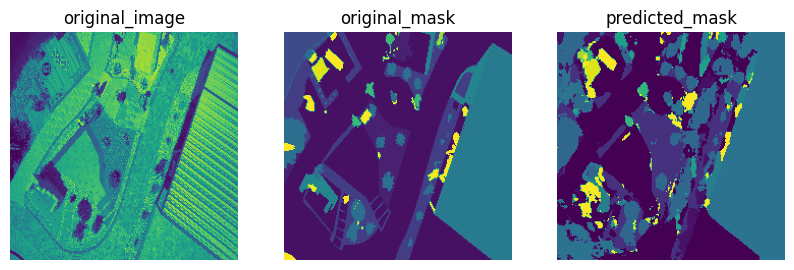

In [33]:
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("original_image")
plt.savefig("original_image.jpg") 
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("original_mask")
plt.savefig("original_mask.jpg")  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("predicted_mask")
plt.savefig("predicted_mask.jpg")

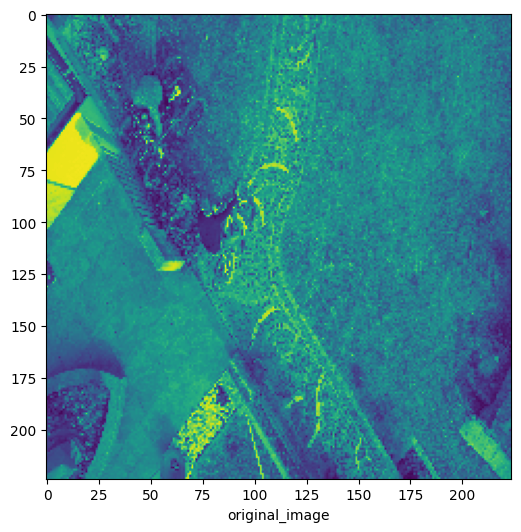

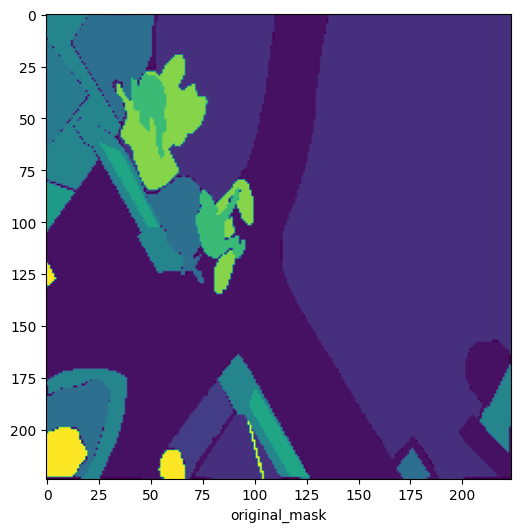

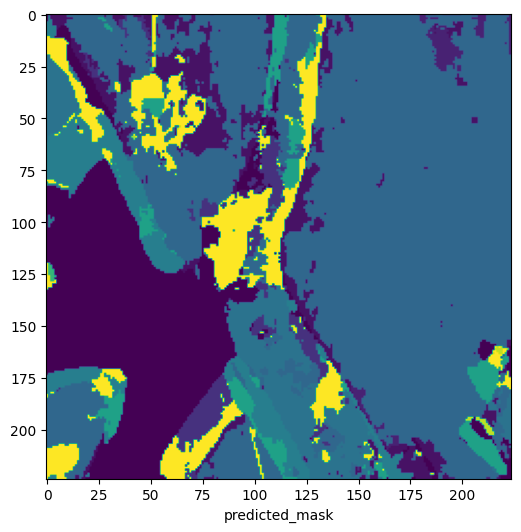

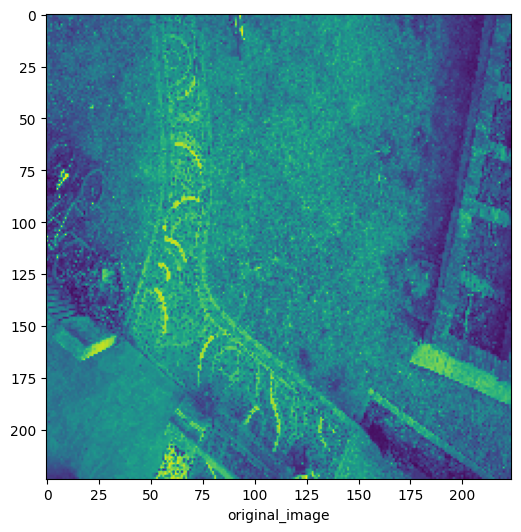

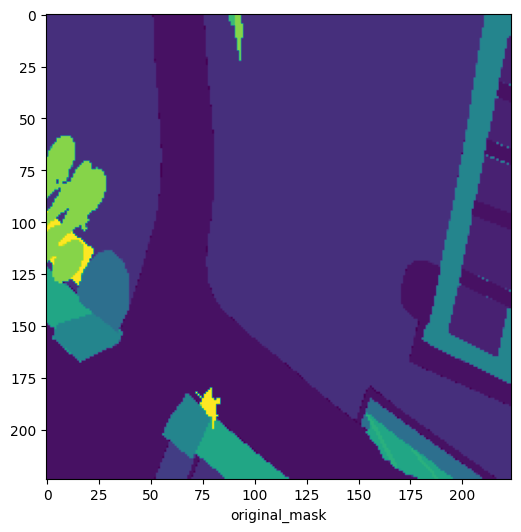

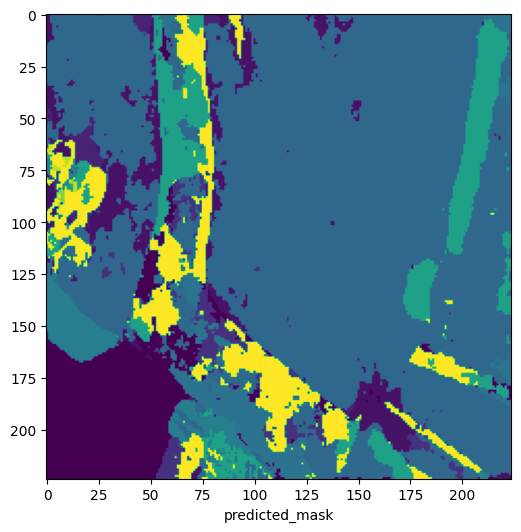

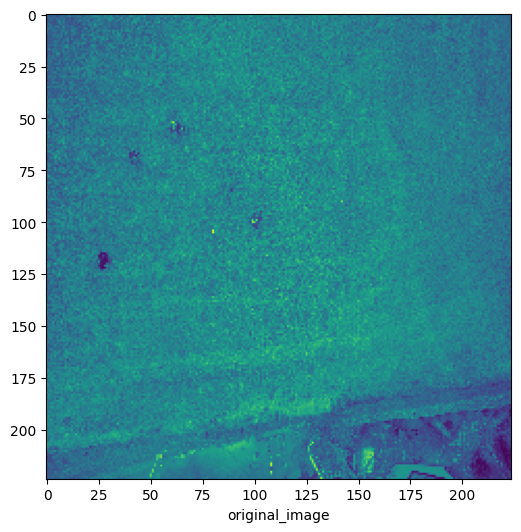

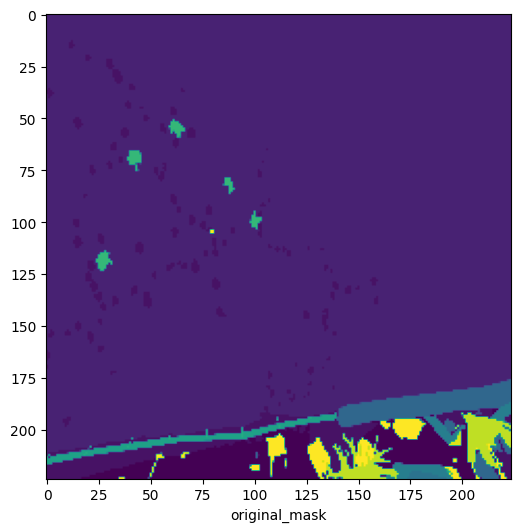

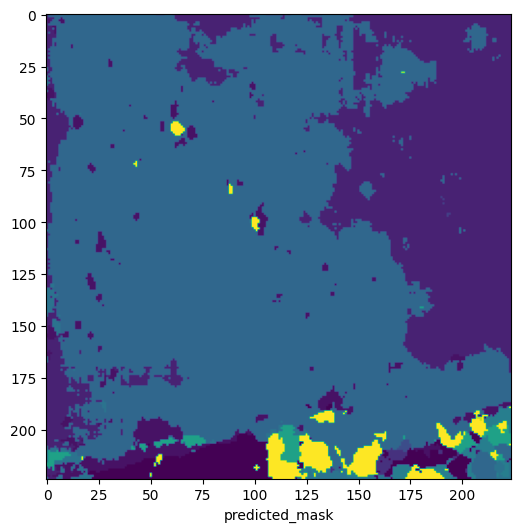

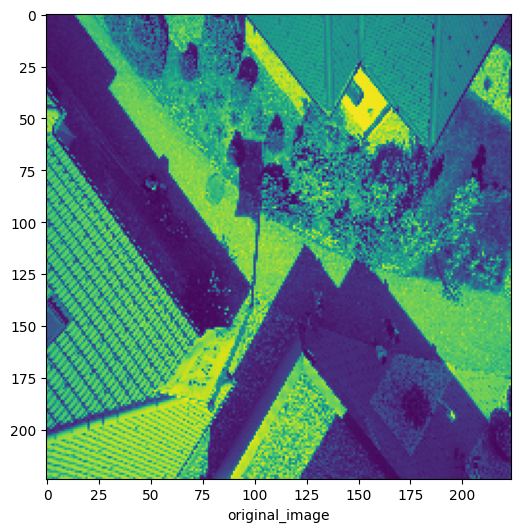

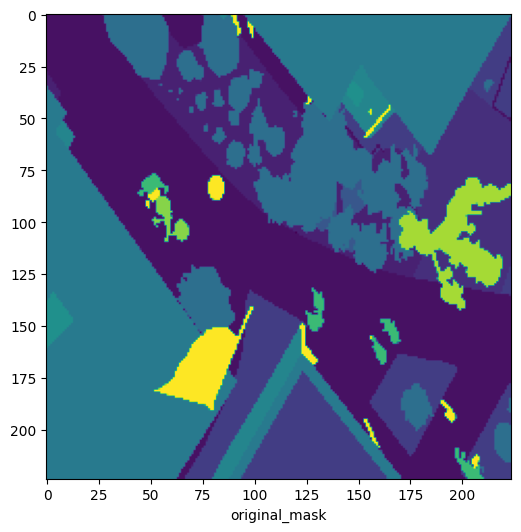

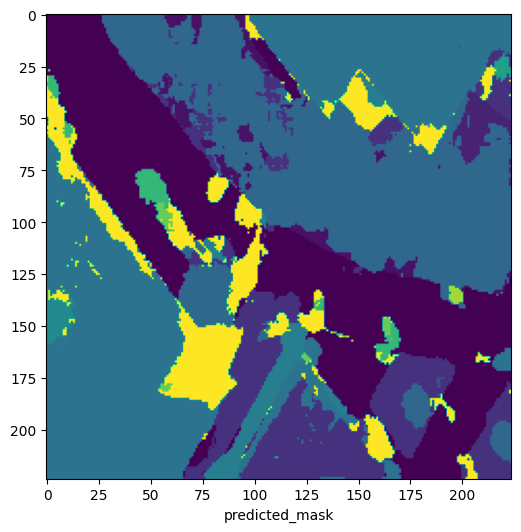

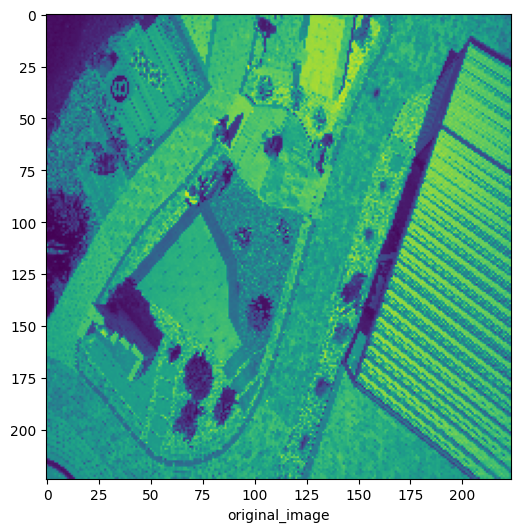

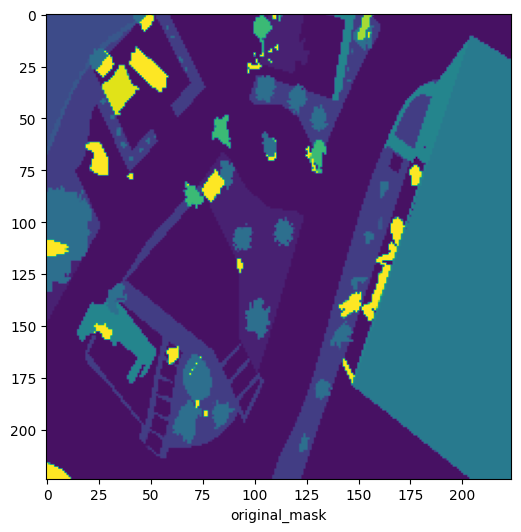

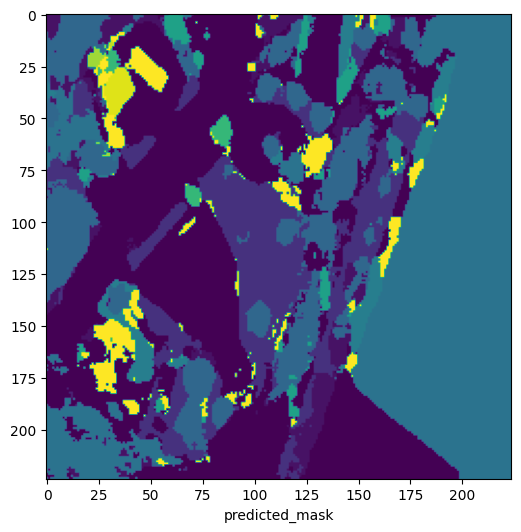

In [32]:

for data in val_dl:
    im, mask = data
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)


    plt.figure(figsize=(6,8))
    #plt.axis("off")
    plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])
    plt.xlabel("original_image")
    plt.savefig("original_image.jpg")
    plt.show()


    plt.figure(figsize=(6,8))
    #plt.axis("off")
    plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])
    plt.xlabel("original_mask")
    plt.savefig("original_mask.jpg")
    plt.show()


    plt.figure(figsize=(6,8))
    #plt.axis("off")
    plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
    plt.xlabel("predicted_mask")
    plt.savefig("predicted_mask.jpg")
    plt.show()
